In [5]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [6]:
# import the model
vggnet = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for p in vggnet.parameters():
    p.requires_grad = False

# set to evaluation mode
vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
img4content = imread('f4051f28-e93f-499d-8757-370413651c38.jpg')
img4style   = imread('Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

/tmp/ipykernel_2480/1678313394.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('f4051f28-e93f-499d-8757-370413651c38.jpg')
/tmp/ipykernel_2480/1678313394.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg')


(3024, 4032, 3)
(3024, 4032, 3)
(7455, 6001, 3)


In [9]:
## These images are really large, which will make training take a long time.

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(512),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)  # ToTensor flips channel dim to front
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 512, 682])
torch.Size([1, 3, 512, 682])
torch.Size([1, 3, 636, 512])


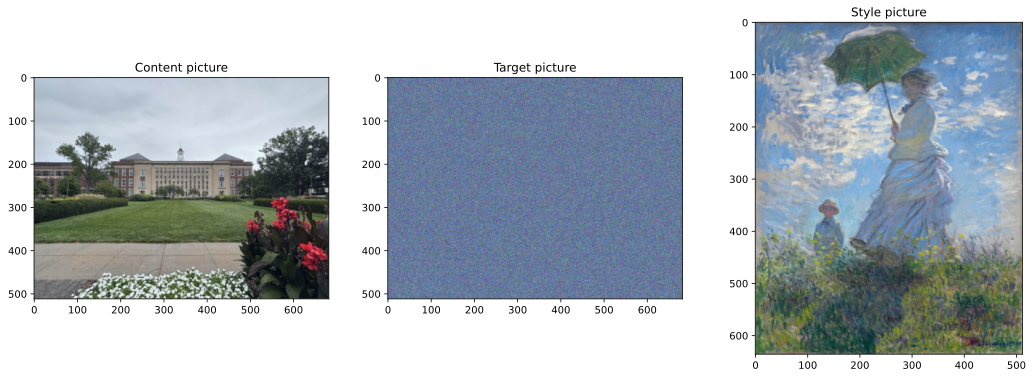

In [10]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))  # at this point, img4content is transformed to 4D, so we need to squeeze it back to 3D, and transpose to bring channel dim to last
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

In [11]:
# A function that returns feature maps

def get_feature_maps(img,net):

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    # print out info from this layer
    # print(layernum,net.features[layernum])

    # process the image through this layer
    # print(net.features[layernum])
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [12]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [13]:
# inspect the output of the function
featmaps,featnames = get_feature_maps(img4content,vggnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 512, 682])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 512, 682])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 256, 341])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 256, 341])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 128, 170])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 128, 170])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 128, 170])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 128, 170])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 64, 85])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 64, 85])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 64, 85])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 64, 85])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 32, 42])
Feature map "ConvLayer_15" is size t

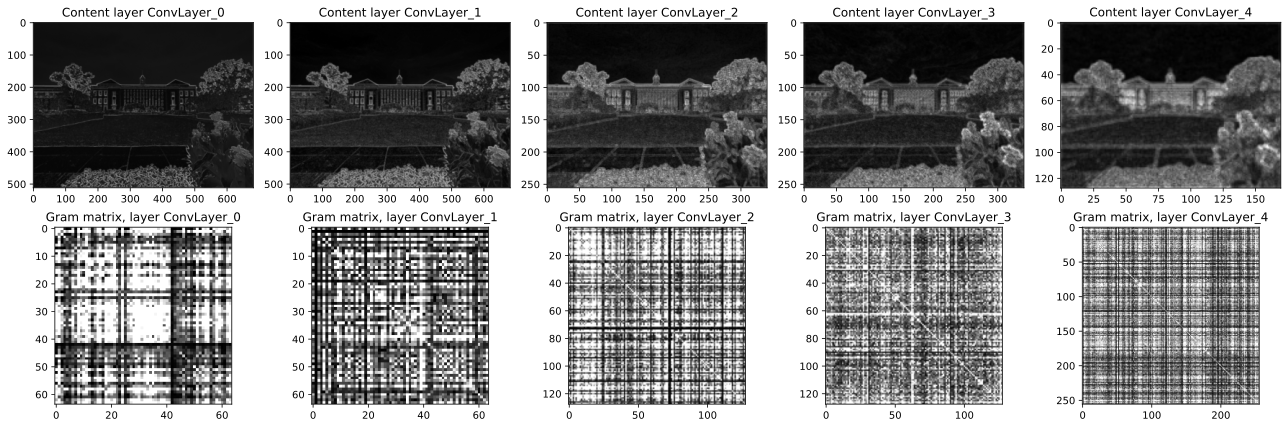

In [14]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = get_feature_maps(img4content,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

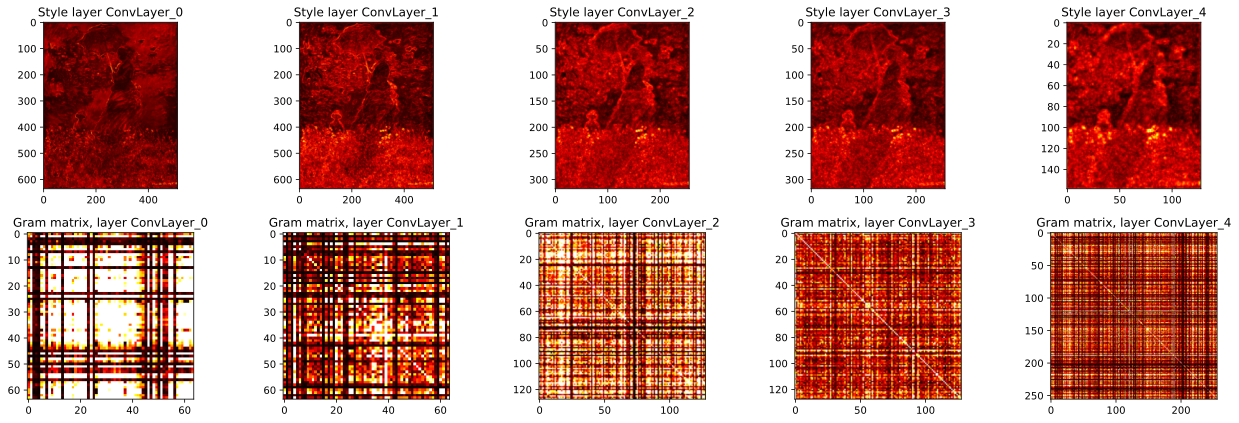

In [15]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = get_feature_maps(img4style,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

In [16]:
# which layers to use
layers4content = ['ConvLayer_1', 'ConvLayer_3' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

### Train

In [17]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):
  print('Epoch %d/%d'%(epochi+1,numepochs))
  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = get_feature_maps(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


Epoch 1/1500
Epoch 2/1500
Epoch 3/1500
Epoch 4/1500
Epoch 5/1500
Epoch 6/1500
Epoch 7/1500
Epoch 8/1500
Epoch 9/1500
Epoch 10/1500
Epoch 11/1500
Epoch 12/1500
Epoch 13/1500
Epoch 14/1500
Epoch 15/1500
Epoch 16/1500
Epoch 17/1500
Epoch 18/1500
Epoch 19/1500
Epoch 20/1500
Epoch 21/1500
Epoch 22/1500
Epoch 23/1500
Epoch 24/1500
Epoch 25/1500
Epoch 26/1500
Epoch 27/1500
Epoch 28/1500
Epoch 29/1500
Epoch 30/1500
Epoch 31/1500
Epoch 32/1500
Epoch 33/1500
Epoch 34/1500
Epoch 35/1500
Epoch 36/1500
Epoch 37/1500
Epoch 38/1500
Epoch 39/1500
Epoch 40/1500
Epoch 41/1500
Epoch 42/1500
Epoch 43/1500
Epoch 44/1500
Epoch 45/1500
Epoch 46/1500
Epoch 47/1500
Epoch 48/1500
Epoch 49/1500
Epoch 50/1500
Epoch 51/1500
Epoch 52/1500
Epoch 53/1500
Epoch 54/1500
Epoch 55/1500
Epoch 56/1500
Epoch 57/1500
Epoch 58/1500
Epoch 59/1500
Epoch 60/1500
Epoch 61/1500
Epoch 62/1500
Epoch 63/1500
Epoch 64/1500
Epoch 65/1500
Epoch 66/1500
Epoch 67/1500
Epoch 68/1500
Epoch 69/1500
Epoch 70/1500
Epoch 71/1500
Epoch 72/1500
E

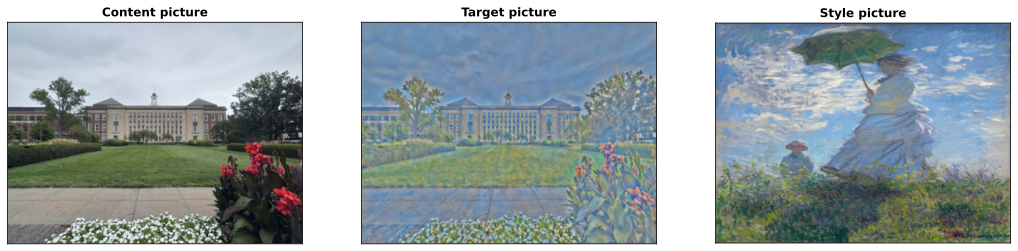

In [18]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

target_pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(target_pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [19]:
plt.imsave('target_pic7.png', target_pic)

In [20]:
target_pic

array([[[0.6344093 , 0.5994683 , 0.54429346],
        [0.554647  , 0.6166748 , 0.72889453],
        [0.5315218 , 0.57446456, 0.68387365],
        ...,
        [0.40948004, 0.5667429 , 0.760823  ],
        [0.47963473, 0.5378603 , 0.7524747 ],
        [0.21995687, 0.5491646 , 0.73674864]],

       [[0.5290572 , 0.6662994 , 0.5550693 ],
        [0.50012803, 0.53428245, 0.7697188 ],
        [0.49737385, 0.5903233 , 0.66801953],
        ...,
        [0.46584722, 0.58401924, 0.60616815],
        [0.49222288, 0.5468343 , 0.65862286],
        [0.2935525 , 0.6348763 , 0.6987651 ]],

       [[0.49067068, 0.59351027, 0.64816195],
        [0.47442487, 0.57236814, 0.70558965],
        [0.47051865, 0.6017347 , 0.6424551 ],
        ...,
        [0.45828754, 0.5469419 , 0.71948236],
        [0.45550686, 0.58062106, 0.6489369 ],
        [0.42337143, 0.5673904 , 0.64530665]],

       ...,

       [[0.40930682, 0.55660075, 0.6985876 ],
        [0.4777603 , 0.57511646, 0.6099091 ],
        [0.4532364 , 0